In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.Q_BAI import Q_SAR, uniform_sampling, Q_UGapEb
from codes.Environment import Mixture_AbsGau, setup_env, Exp, generate_samples
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva, plot_eva_m

import pickle

%matplotlib inline

# Generate samples setting

In [2]:
budget = 5000
num_exper = 1000

# Group One Design

The idea is to show median/0.8-quantile and mean has different order of preference of arms. 

## Three arms example

In [15]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                     ],
     Exp: [[1/3.6]]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.5 # quantile level
est_flag = False # True: estimate the lower bound of hazard rate L; False: use the true L

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.2777777777777778]]}


In [16]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
}

for key in quantiles.keys():
    print(key)
    quantiles[key] = list(np.around(np.array(quantiles[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row([str(tau) + '-Quantile'] + quantiles[key]+ [arm_name_dict[np.argmax(quantiles[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    t.add_row(['L']+ Ls[key]+ [arm_name_dict[np.argmax(Ls[key])]])
    print(t)
    print()


Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]]Exp_[[0.2777777777777778]]
+--------------+--------------------+---------------------+--------------------+----------+
|     Eva      |         A          |          B          |         C          | Best Arm |
+--------------+--------------------+---------------------+--------------------+----------+
| 0.5-Quantile |        1.02        |         3.48        |        2.48        |    B     |
|     Mean     |        1.2         |         3.55        |        3.61        |    C     |
|      L       | 0.5319230405352436 | 0.08627731882651153 | 0.2777777777777778 |    A     |
+--------------+--------------------+---------------------+--------------------+----------+



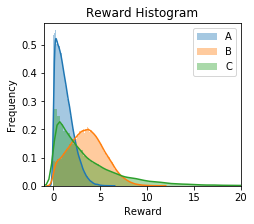

In [5]:
plot_hist(samples)

## 20 Arms

In [6]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1],
                     ],
     Exp: [[1/3.6],
          [1/3.6],
          [1/3.6],
          [1/3.6],
          ]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.5 # quantile level
est_flag = False # True: estimate the lower bound of hazard rate L; False: use the true L

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.2777777777777778], [0.2777777777777778], [0.2777777777777778], [0.2777777777777778]]}


In [7]:
group_one_list = []


for i in range(num_exper):
    group_one_list.append(generate_samples(environments[0], tau, budget))

file_name = 'group_one_samples_tau'+ str(tau) + '_budget' + str(budget) + '_exper' + str(num_exper) + '.pickle'
with open(file_name, 'wb') as handle:
    pickle.dump(group_one_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Group Two Design 

The idea is to show the (smallest) gap median/0.8 quantiles is much bigger than the gap for means, so that it is easier to identify the best arms.

## Three arms example

In [8]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                     ],
     Exp: [[1/3.6]]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.8 # quantile level
est_flag = False # True: estimate the lower bound of hazard rate L; False: use the true L

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.2777777777777778]]}


In [9]:

arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
}

for key in quantiles.keys():
    print(key)
    quantiles[key] = list(np.around(np.array(quantiles[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row([str(tau) + '-Quantile'] + quantiles[key]+ [arm_name_dict[np.argmax(quantiles[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    t.add_row(['L']+ Ls[key]+ [arm_name_dict[np.argmax(Ls[key])]])
    print(t)
    print()


Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1]]Exp_[[0.2777777777777778]]
+--------------+--------------------+---------------------+--------------------+----------+
|     Eva      |         A          |          B          |         C          | Best Arm |
+--------------+--------------------+---------------------+--------------------+----------+
| 0.8-Quantile |        1.93        |         5.18        |        5.74        |    C     |
|     Mean     |        1.2         |         3.56        |        3.58        |    C     |
|      L       | 0.5319230405352436 | 0.08627731882651153 | 0.2777777777777778 |    A     |
+--------------+--------------------+---------------------+--------------------+----------+



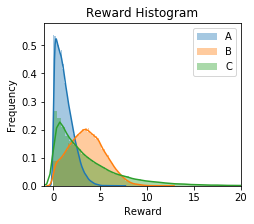

In [10]:
plot_hist(samples)

## 20 Arms

In [11]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1],
                     ],
     Exp: [[1/3.6]
          ]
    } # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.8 # quantile level
est_flag = False # True: estimate the lower bound of hazard rate L; False: use the true L

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.2777777777777778], [0.2777777777777778], [0.2777777777777778], [0.2777777777777778]]}


In [12]:
group_two_list = []

for i in range(num_exper):
    group_two_list.append(generate_samples(environments[0], tau, budget))

file_name = 'group_one_samples_tau'+ str(tau) + '_budget' + str(budget) + '_exper' + str(num_exper) + '.pickle'
with open(file_name, 'wb') as handle:
    pickle.dump(group_two_list, handle, protocol=pickle.HIGHEST_PROTOCOL)